In [5]:
import cv2 as cv
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

from PIL import Image


def draw_all_kpts(img_np, kpts_original, kpts_transformed, title):
    for kpt in kpts_original:
        kpt.size = 50
        kpt.angle = math.pi / 2
    for kpt in kpts_transformed:
        kpt.size = 25
        kpt.angle = 0
    kpts_all_cv = kpts_original + kpts_transformed
    img_kpts = img_np.copy()
    cv.drawKeypoints(img_kpts, kpts_all_cv, img_kpts, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(9, 9))
    title = "{}: {} - transformed of size 25, original of size 50".format(title, len(kpts_all_cv))
    plt.title(title)
    plt.imshow(img_kpts)
    plt.show()
    plt.close()


def mnn_generic(pts1, pts2, err_th):
    assert len(pts1.shape) == len(pts2.shape)

    pts1_r, pts2_r = pts1, pts2
    if len(pts1.shape) == 1:
        pts1_r, pts2_r = pts1[:, None].repeat(1, 2), pts2[:, None].repeat(1, 2)
        pts1_r[:, 1] = 0.0
        pts2_r[:, 1] = 0.0

    d_mat = torch.cdist(pts1_r, pts2_r)

    min0_values, min0_indices = torch.min(d_mat, dim=0)
    min1_values, min1_indices = torch.min(d_mat, dim=1)

    mask = min1_indices[min0_indices] == torch.arange(0, min0_indices.shape[0])
    mask2_boolean = mask & (min0_values < err_th)

    verify = True
    if verify:
        for i in range(min0_indices.shape[0]):
            if mask2_boolean[i]:
                assert min1_indices[min0_indices[i]] == i
                assert min0_values[i] < err_th

    mask1 = min0_indices[mask2_boolean]
    pts1_new = pts1[mask1]
    pts2_new = pts2[mask2_boolean]

    mask2 = mask2_boolean.nonzero()[:, 0]
    return pts1_new, pts2_new, mask1, mask2


def rotate_experiment(file_path, detector, rotations_90_deg):
    print(f"experiment for n rotations: {rotations_90_deg}")

    img_np_o = np.array(Image.open(file_path))

    kpts_0_cv, _ = detector.detect(img_np_o, mask=None)
    kpts_0 = torch.tensor([[kp.pt[1], kp.pt[0]] for kp in kpts_0_cv])

    img_np_r = np.rot90(img_np_o, rotations_90_deg, [0, 1])

    kpts_1_cv, _ = detector.detect(img_np_r, mask=None)
    kpts_1 = torch.tensor([[kp.pt[1], kp.pt[0]] for kp in kpts_1_cv])

    coord0_max = img_np_r.shape[0] - 1
    coord1_max = img_np_r.shape[1] - 1
    for i in range(4 - rotations_90_deg):
        kpts_10_new = coord1_max - kpts_1[:, 1]
        kpts_11_new = kpts_1[:, 0].clone()
        kpts_1[:, 0] = kpts_10_new.clone()
        kpts_1[:, 1] = kpts_11_new.clone()
        coord1_max, coord0_max = coord0_max, coord1_max

    for i, e_kpts_1_cv in enumerate(kpts_1_cv):
        e_kpts_1_cv.pt = (kpts_1[i, 1].item(), kpts_1[i, 0].item())

    print("number of kpts: {}, {}".format(kpts_0.shape[0], kpts_1.shape[0]))

    # mnn
    kpts_0_new_1d, kpts_1_new_1d, mask_00, mask_10 = mnn_generic(kpts_0, kpts_1, err_th=4)
    print("number of filtered kpts: {}, {}".format(kpts_0_new_1d.shape[0], kpts_1_new_1d.shape[0]))

    distances = torch.linalg.norm(kpts_1_new_1d - kpts_0_new_1d, axis=1)
    print("distances between matching keypoints - min: {}, max: {}".format(distances.min(), distances.max()))

    def get_lists(i_l, torch_mask):
        m_l = torch_mask.tolist()
        matched_l, unmatched_l = [], []
        for index, item in enumerate(i_l):
            if index in m_l:
                matched_l.append(item)
            else:
                unmatched_l.append(item)
        return matched_l, unmatched_l

    # visualize the matched and umatched keypoints
    kpts_0_cv_matched, kpts_0_cv_unmatched = get_lists(kpts_0_cv, mask_00)
    kpts_1_cv_matched, kpts_1_cv_unmatched = get_lists(kpts_1_cv, mask_10)
    print("Matched keypoints: {}".format(len(kpts_0_cv_matched) + len(kpts_1_cv_matched)))
    print("Unmatched keypoints: {}".format(len(kpts_0_cv_unmatched) + len(kpts_1_cv_unmatched)))
    draw_all_kpts(img_np_o, kpts_0_cv_matched, kpts_1_cv_matched, "matched keypoints")
    draw_all_kpts(img_np_o, kpts_0_cv_unmatched, kpts_1_cv_unmatched, "unmatched keypoints")

    mean = (kpts_1_new_1d - kpts_0_new_1d).mean(dim=0)
    var = (kpts_1_new_1d - kpts_0_new_1d).var(dim=0)
    print("mean: {}, variance: {}".format(mean, var))


def rotate_experiment_loop(detector, img_to_show):
    img_dir = "demo_imgs"
    files = ["{}/{}".format(img_dir, fn) for fn in os.listdir(img_dir)][:img_to_show]
    for file_path in files:
        for rots in range(1, 4):
            rotate_experiment(file_path, detector, rots)


experiment for n rotations: 1
number of kpts: 700, 715
number of filtered kpts: 600, 600
distances between matching keypoints - min: 0.0, max: 3.605551242828369
Matched keypoints: 1200
Unmatched keypoints: 215


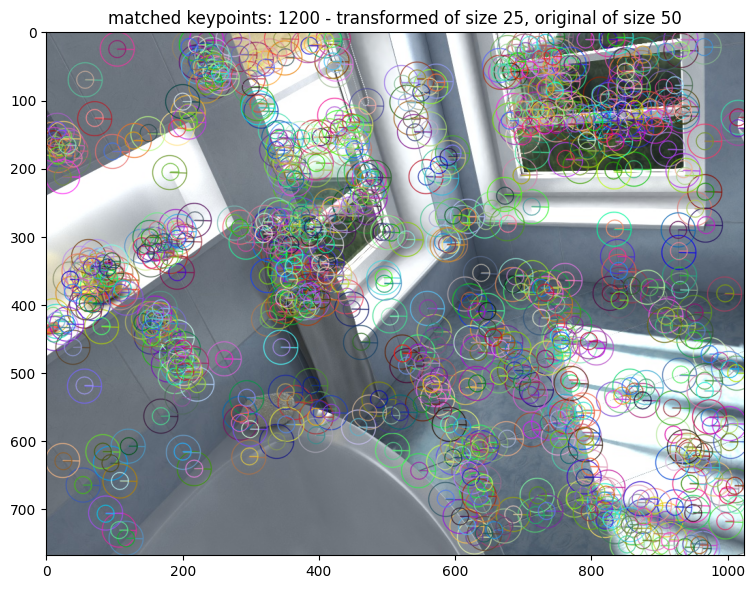

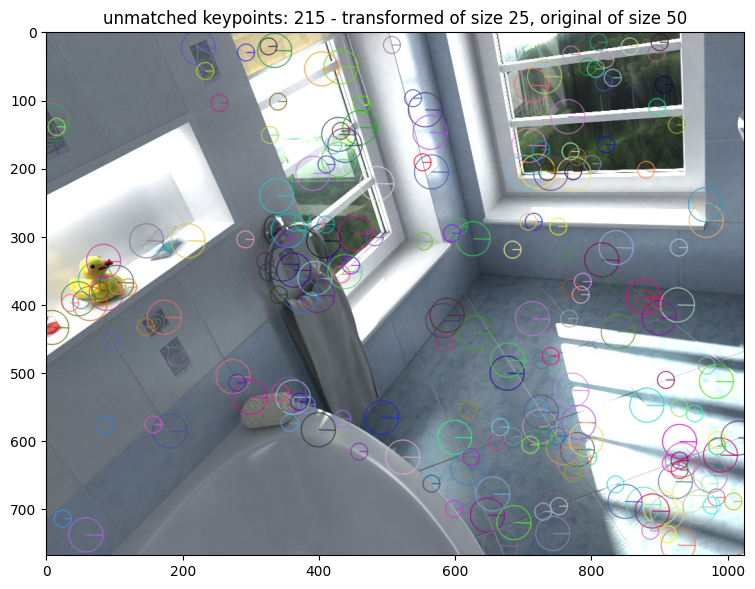

mean: tensor([-0.0100,  0.1633]), variance: tensor([0.4673, 0.5409])
experiment for n rotations: 2
number of kpts: 700, 728
number of filtered kpts: 607, 607
distances between matching keypoints - min: 0.0, max: 3.605551242828369
Matched keypoints: 1214
Unmatched keypoints: 214


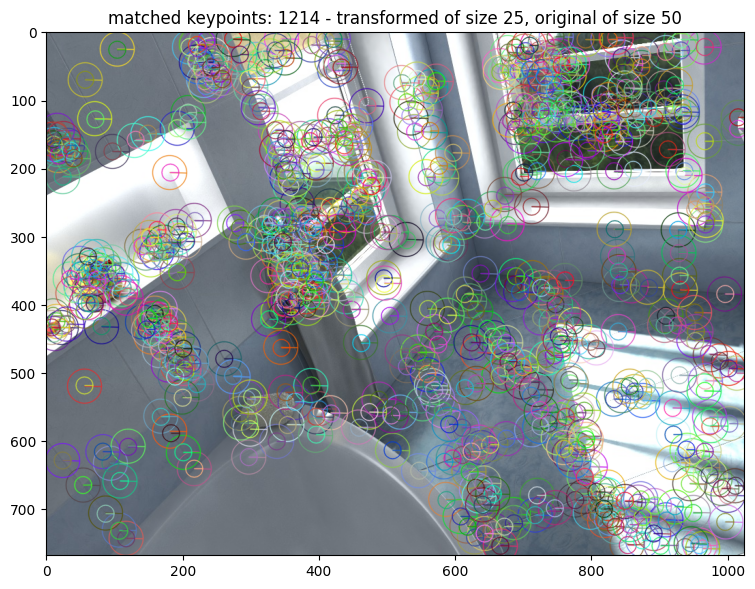

In [ ]:
from superpoint_local import SuperPointDetector
detector = SuperPointDetector()
rotate_experiment_loop(detector, img_to_show=1)
